# An automated pipeline to create an atlas of in-situ hybridization gene expression data in the adult marmoset brain (ISBI 2023, Poon, C., et al.)

# UNet based semantic segmentation model with contrastive loss

In [1]:
# based on 20221027

### Import libraries

In [1]:
import os
import re
import glob
import random
import numpy as np
import time
import cv2

from PIL import Image

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms.functional as tf
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

torch.manual_seed(42)

In [ ]:
import torch
!echo $CUDA_VISIBLE_DEVICES
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())
print(torch.backends.cudnn.version())
print(torch.version.cuda)

### Encoder and decoder blocks of UNet

In [8]:
#%%  encoder and decoder from UNet

def convbnrelu2(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same', bias=True),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(), 
    )

def convbnrelu2_T(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=True),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(), 
    )

class unet_encoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=16):  #64
        super(unet_encoder, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.init_features = init_features
        
        self.conv_down1 = convbnrelu2(in_channels, init_features)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # not sure if this is right    
        self.conv_down2 = convbnrelu2(init_features, init_features*2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # not sure if this is right    
        
        self.bottleneck = convbnrelu2(init_features*2, init_features*4)  #fc per channel, kernel size=1, reduces params
    
    def forward(self, x):
        enc1 = self.conv_down1(x)
        
        enc2 = self.conv_down2(self.maxpool1(enc1))
        bottleneck = self.bottleneck(self.maxpool2(enc2))
        
        return bottleneck#, enc_list

class unet_decoder(nn.Module):
    def __init__(self, init_features=16, out_channels=1):  #64
        super(unet_decoder, self).__init__()
    
        #self.convT2 = nn.ConvTranspose2d(init_features*4, init_features*2, kernel_size=2, stride=2, bias=True)
        self.convT2 = convbnrelu2_T(init_features*4, init_features*2)
        self.conv_up2 = convbnrelu2(init_features*2, init_features*2)
        
        
        #self.convT1 = nn.ConvTranspose2d(init_features*2, init_features, kernel_size=2, stride=2, bias=True)
        self.convT1 = convbnrelu2_T(init_features*2, init_features)
        self.conv_up1 = convbnrelu2(init_features, init_features)   
        
        #init_features =16
        #out_channels=1
        self.final_layer = nn.Conv2d(init_features, out_channels, kernel_size=1)

    def forward(self, bottleneck):
        
        dec2 = self.convT2(bottleneck)
        dec2 = self.conv_up2(dec2)
        
        dec1 = self.convT1(dec2)
        dec1 = self.conv_up1(dec1)
        
        out = self.final_layer(dec1)
        out = torch.sigmoid(out)
        
        return(out)

### Define contrastive transformations (see SimCLR paper for details)

In [9]:
class ContrastiveTransformations:
    def __init__(self, flag, n_views=2):
        if flag == 'augm':
            self.base_transforms = augm_transforms
        elif flag == 'noaugm':
            self.base_transforms = noaugm_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

    
augm_transforms = transforms.Compose(
    [
        transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
    ]
)

noaugm_transforms = transforms.Compose(
    [
    ]
)    
print("ok")

ok


### Dataset used for both supervised and contrastive learning

In [10]:
# %% class ishDataset, char edit
class ishDataset_sim(Dataset):
    def __init__(self, root_dir: str, img_suffix: str, label_suffix: str): 
        self.root_dir = root_dir
        self.img_path = os.path.join(root_dir, img_suffix)
        self.label_path = os.path.join(root_dir, label_suffix)
        self.img_fn_list = sorted(glob.glob(self.img_path+'*.jpg'))  
        self.label_fn_list = sorted(glob.glob(self.label_path+'*.jpg')) 
        
        self.img_list = []
        self.label_list = []
        
        self.fast = False
        self.fast2 = True
        self.tt = transforms.ToTensor()
        
        if self.fast2:
            for idx in range(len(self.img_fn_list)):                
                im = self.tt(Image.open(self.img_fn_list[idx]))
                lab = self.tt(Image.open(self.label_fn_list[idx]))
                
                im, lab = self.transform(im, lab)
                
                self.img_list += [im]
                self.label_list+= [lab]
     
    def __len__(self):
        return len(self.img_fn_list)
    
    def transform(self, image, label): 
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(400,400))  
        image = tf.crop(image, i, j, h, w)
        label = tf.crop(label, i, j, h, w)

        return image, label
    
    def __getitem__(self, idx):
        if self.fast2: 
            image, label = self.img_list[idx], self.label_list[idx]
        return image, label
        
        
print("ok")

ok


### Dataset used for contrastive learning only

In [11]:
class ishDataset_c(Dataset):
    def __init__(self, root_dir: str):  
        self.img_path = root_dir
        self.img_fn_list = sorted(glob.glob(self.img_path+'*.jpg'))  
        self.img_list = []

        self.fast = True
        self.tt = transforms.ToTensor()
        
        if self.fast:
            for idx in range(len(self.img_fn_list)):
                im = Image.open(self.img_fn_list[idx])
                im = self.transform(im)
                im = self.tt(im)
                self.img_list += [im]
        
    def __len__(self):
        return len(self.img_fn_list)
    
    def transform(self, image): 
        i, j, h, w = transforms.RandomResizedCrop.get_params(image,scale=(0.9, 1.5), ratio=(0.9, 1.33))  
        output_size=(400,400)
        image = tf.resized_crop(image, i, j, h, w, output_size)

        if random.random() > 0.5:
            image = tf.hflip(image)

        return image
    
    def __getitem__(self, idx):
        if self.fast:  
            image = self.img_list[idx]

        return image
        
        
print("ok")

ok


### Load datasets and visualize some samples from dataloaders

In [ ]:
trainsc_data = ishDataset_sim(root_dir='/home/charissa/shimogori/shimogori_adult/ish/new/',
                          img_suffix='img_char_train4/',   
                          label_suffix='seg_char_train/',
                          ) 

test_data = ishDataset_sim(root_dir='/home/charissa/shimogori/shimogori_adult/ish/new/',
                          img_suffix='img_char_test2/',  
                          label_suffix='seg_char_test/',
                          )  

trainc_data = ishDataset_c(root_dir='/home/charissa/shimogori/shimogori_adult/ish/new/im_only/jpg3/')

print('train_data size:',len(trainsc_data))
trainsplit_size = int(0.7 * len(trainsc_data))
valsplit_size = len(trainsc_data) - trainsplit_size
print('training_size:', trainsplit_size, 'val_size:', valsplit_size)
trainsplit_data, valsplit_data = random_split(trainsc_data, [trainsplit_size, valsplit_size])

# dataloader for supervised and contrastive learning
trainsc_dataloader = DataLoader(trainsplit_data, batch_size=8, shuffle=True, drop_last=True, num_workers=1)
# dataloader for contrastive learning only
trainc_dataloader = DataLoader(trainc_data, batch_size=8, shuffle=True, drop_last=True, num_workers=1)
# validation and test dataloaders
val_dataloader = DataLoader(valsplit_data, batch_size=8, shuffle=False, drop_last=True, num_workers=1)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False, drop_last=True) 

train_dataloaders = {"con": trainc_dataloader, "sup": trainsc_dataloader}

                                
if True:
    x, y = next(iter(trainsc_dataloader))
    print(x[0].shape)  
    print(y[0].shape)
    for s in range(4):
        plt.subplot(221)
        plt.imshow(np.transpose(x[s], (1,2,0)), cmap='gray')
        plt.title('train sup images')
        plt.subplot(222)
        plt.imshow(np.transpose(y[s], (1,2,0)), cmap='gray')
        plt.title('train sup labels')
        plt.show()

    print("ok")
    print(trainsc_dataloader.__len__())

In [ ]:
if True:
    x, y = next(iter(val_dataloader))
    print(x[0].shape)  # supx_s[0][0] if stay tensor
    print(y[0].shape)
    for s in range(4):
        plt.subplot(221)
        plt.imshow(np.transpose(x[s], (1,2,0)), cmap='gray')
        plt.title('train sup images')
        plt.subplot(222)
        plt.imshow(np.transpose(y[s], (1,2,0)), cmap='gray')
        plt.title('train sup labels')
        plt.show()

    print("ok")
    print(val_dataloader.__len__())

torch.Size([3, 400, 400])


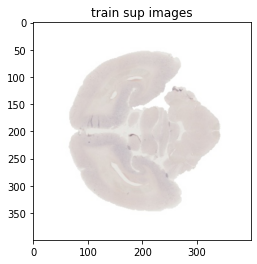

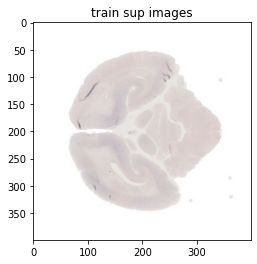

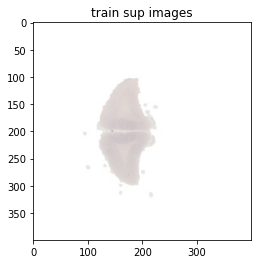

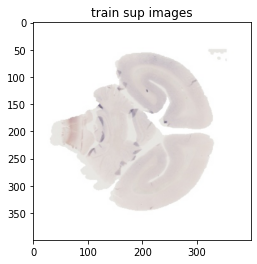

ok
23


In [13]:
if True:
    x = next(iter(trainc_dataloader))
    print(x[0].shape)  # supx_s[0][0] if stay tensor
    for s in range(4):
        plt.imshow(np.transpose(x[s], (1,2,0)), cmap='gray')
        plt.title('train sup images')
        plt.show()

    print("ok")
    print(trainc_dataloader.__len__())

### Segmentation model

In [14]:
from IPython.display import clear_output

class SegModel(pl.LightningModule):
    def __init__(self, hidden_dim, bottleneck_ch, bottleneck_h, bottleneck_w, lr, temperature, weight_decay, p_conloss):
        super(SegModel, self).__init__()
        self.save_hyperparameters()
        
        self.automatic_optimization = False
        self.hidden_dim=hidden_dim
        self.lr = lr  #5e-4
        self.temperature = temperature
        self.weight_decay = weight_decay
        self.batch_size = 8
        self.bottleneck_ch = bottleneck_ch
        self.bottleneck_w = bottleneck_w
        self.bottleneck_h = bottleneck_h
        self.p_conloss = p_conloss
        self.counter = 0
        self.bce = torch.nn.BCELoss()  
    
        self.encoder = unet_encoder(in_channels=3, out_channels=1, init_features=16)  #64
        self.decoder = unet_decoder(init_features=16, out_channels=1)  #64
        
        self.trainsc_data = trainsplit_data
        self.trainc_data = trainc_data
        self.valset = valsplit_data
        self.testset = test_data
        
        self.ct_null = ContrastiveTransformations(flag='noaugm', n_views=2)
        self.ct = ContrastiveTransformations(flag='augm', n_views=2)
        
        self.conv2d = torch.nn.Conv2d(
            in_channels=64,  #1024
            out_channels=hidden_dim*4,
            kernel_size=[bottleneck_w, bottleneck_h],
            stride = [bottleneck_h, bottleneck_w]
        )
        self.mlp = nn.Sequential( 
            self.conv2d,
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(64*hidden_dim, hidden_dim), 
            nn.Linear(hidden_dim,4*2)
        )
        
    
    def train_dataloader(self):
        trainsc_dataloader = DataLoader(self.trainsc_data, batch_size=self.batch_size, shuffle=True, drop_last=True, num_workers=1)
        trainc_dataloader = DataLoader(self.trainc_data, batch_size=self.batch_size, shuffle=True, drop_last=True, num_workers=1)
        train_dataloaders = {"con": trainc_dataloader, "sup": trainsc_dataloader}
        return train_dataloaders  
        
    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=self.batch_size, shuffle=False, drop_last=True, num_workers=1)
    
    def forward(self, x):        
        bottleneck = self.encoder(x)
        preds = self.decoder(bottleneck)
        return (bottleneck, preds)
    
    def training_step(self, batch, batch_idx) :  # , batch_nb
        
        if not self.automatic_optimization:
            opt = self.optimizers()
            opt.zero_grad()

            
        img_train, mask_train = batch["sup"] 
        img_nomi = batch["con"]
        
        print('img_train len:', len(img_train))
        print('mask_train len:', len(mask_train))


        # INFO NCE LOSS #         

        img_train_c = self.ct(img_train)
        mask_train_c = self.ct_null(mask_train)
        imgcat_train_c = torch.cat(img_train_c, dim=0)
        bottleneck_train_c, preds_train_c = self.forward(imgcat_train_c)

        loss_nce_train = self.info_nce_loss(bottleneck_train_c, mode='train')
        self.log("train_contr_loss", loss_nce_train, on_epoch=True)        
        
        img_nomi_c = self.ct(img_nomi)
        imgcat_nomi_c = torch.cat(img_nomi_c, dim=0)
        bottleneck_nomi_c, _= self.forward(imgcat_nomi_c)
        loss_nce_nomi = self.info_nce_loss(bottleneck_nomi_c, mode='train')
        self.log("train_only_contrastive", loss_nce_nomi, on_epoch=True) 
        
        
        
        # SUPERVISED LOSS #
       
        mask_train2 = (mask_train > 0.5).to(dtype=torch.float32)
        bottleneck_train_s, preds_train_s = self.forward(img_train)
        loss_sup_train = self.bce(preds_train_s, mask_train2)
        self.log("train_sup_loss", loss_sup_train, on_epoch=True)

        train_loss = loss_sup_train + (self.p_conloss/10)*loss_nce_train + (self.p_conloss/100)*loss_nce_nomi
        
        self.log("train_loss", train_loss, on_epoch=True)

        self.counter += 1

        if not self.automatic_optimization:
            print('if not self.automatic_optimization:')
            self.manual_backward(loss_sup_train + 0.5*loss_nce_train)
            opt.step()
            
        else:
            return {'loss' : train_loss}
    
        
    
    def validation_step(self, batch, batch_idx):  # 
        if self.counter % 5 == 0:
            clear_output(wait=True)
            x,y = batch         
            

            # INFO NCE LOSS #  

            x_c = self.ct(x)
            y_c = self.ct_null(y)
            x_cat_c = torch.cat(x_c, dim=0)
            y_cat_c = torch.cat(y_c, dim=0)

            b_c, y_hat_c = self.forward(x_cat_c)
            #print('b_c:',b_c.shape)
            loss_c = self.info_nce_loss(b_c, mode='train')
            loss_cs = self.bce(y_hat_c, y_cat_c)
            self.log("val_supduringcont_loss", loss_cs, on_epoch=True)

            self.log("val_cont_loss", loss_c, on_epoch=True)
            print('val_step, nce loss:', loss_c.item())


            # SUPERVISED LOSS #

            y = (y > 0.5).to(dtype=torch.float32)

            b_s, y_hat_s = self.forward(x)
            loss_s = self.bce(y_hat_s, y)

            self.log("val_sup_loss", loss_s, on_epoch=True)
            
            # visualize validation outputs
            if True:
                cyhats = torch.cat((y_hat_c.detach().cpu()[0,0,...], y_hat_c.detach().cpu()[1,0,...],
                                     y_hat_c.detach().cpu()[6,0,...], y_hat_c.detach().cpu()[7,0,...]), dim=1
                                     )
                plt.figure(figsize = (20,5))
                plt.imshow(cyhats, cmap='gray')
                plt.title('contrastive: y_hats')
                plt.show()

                cx1 = torch.cat(
                            (x_c[0].detach().cpu()[0,0,...], x_c[0].detach().cpu()[1,0,...],
                              x_c[0].detach().cpu()[2,0,...], x_c[0].detach().cpu()[3,0,...]),dim=1   
                        )
                plt.figure(figsize = (20,5))
                plt.imshow(cx1, cmap='gray')
                plt.title('contrastive: x')
                plt.show()

                cy = torch.cat(
                            (y_c[0].detach().cpu()[0,0,...], y_c[0].detach().cpu()[1,0,...],
                             y_c[0].detach().cpu()[2,0,...], y_c[0].detach().cpu()[3,0,...]),dim=1     
                        )
                plt.figure(figsize = (20,5))
                plt.imshow(cy, cmap='gray')
                plt.title('contrastive: y')
                plt.show()



                syhats = torch.cat((y_hat_s.detach().cpu()[0,0,...],  y_hat_s.detach().cpu()[1,0,...], 
                                  y_hat_s.detach().cpu()[2,0,...], y_hat_s.detach().cpu()[3,0,...]), dim=1  
                        )
                plt.figure(figsize = (20,5))
                plt.imshow(syhats, cmap='gray')
                plt.title('supervised: y_hats')
                plt.show()

                sx = torch.cat(
                            (x.detach().cpu()[0,0,...], x.detach().cpu()[1,0,...],
                             x.detach().cpu()[2,0,...], x.detach().cpu()[3,0,...]),dim=1)
                plt.figure(figsize = (20,5))
                plt.imshow(sx, cmap='gray')
                plt.title('supervised: x')
                plt.show()

                sy = torch.cat(
                            (y.detach().cpu()[0,0,...], y.detach().cpu()[1,0,...],
                             y.detach().cpu()[2,0,...], y.detach().cpu()[3,0,...]),dim=1 
                        )
                plt.figure(figsize = (20,5))
                plt.imshow(sy, cmap='gray')
                plt.title('supervised: y')
                plt.show()

        
        
    def info_nce_loss(self, bottleneck, mode):
        # from https://theaisummer.com/simclr/
        
        feats = self.mlp(bottleneck)
        mask = (~torch.eye(self.batch_size * 2, self.batch_size * 2, dtype=bool, device=self.device)).float()

        ai_cos = F.cosine_similarity(feats.unsqueeze(1), feats.unsqueeze(0), dim=2)

        sim_ij = torch.diag(ai_cos, self.batch_size) 
        sim_ji = torch.diag(ai_cos, -self.batch_size)  

        positives = torch.cat([sim_ij, sim_ji], dim=0)
        # nominator has positive pairs only
        nominator = torch.exp(positives / self.temperature)
        # denominator has both positive and negative pairs, but mask each element from itself (inverse identity)
        denominator = mask * torch.exp(ai_cos / self.temperature)
       
        all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
        nce_loss = torch.sum(all_losses) / (2 * self.batch_size)
        print('nce_loss:', nce_loss)  # tensor(2.4993)
        
        self.log(mode + "_nce_loss", nce_loss)
        
        return nce_loss
    
   
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters())
        return [opt]#, [sch]
    
    


### Train model

In [ ]:
segmodel = SegModel(hidden_dim=32, bottleneck_ch=64, bottleneck_h=24, bottleneck_w=24, lr=1e-3, temperature=.07, weight_decay=1e-4, p_conloss=1)  

# initialize with pretrained model
pretrain_dir = '/home/charissa/shimogori/shimogori_adult/segmentation/contrastive_learning/lightning_code/csvlogs/20221027_pretraining_epochs100_patch400/version_0/checkpoints/epoch=99-step=18600.ckpt'
pre = torch.load(pretrain_dir)
segmodel.load_state_dict(pre['state_dict'])


ckpt_dir = '/home/charissa/shimogori/shimogori_adult/ish/ckpt/'
if not ckpt_dir:
    os.mkdir(ckpt_dir)

os.makedirs(ckpt_dir,exist_ok=True)

if True:
    print('training with if True:')
    trainer = pl.Trainer(logger=CSVLogger(save_dir = 'csvlogs/', name='20221031_epochs200_pretrained'),
                         accelerator='gpu',
                         gpus=1,
                        devices='gpus', 
                        default_root_dir = ckpt_dir, 
                        enable_progress_bar=False, 
                        enable_model_summary=True, 
                        max_epochs=200)  

    trainer.fit(segmodel)

else:  # pure pytorch
    optimizer = torch.optim.Adam(segmodel.parameters())
    loss = torch.nn.BCELoss()
    segmodel.cuda()
    for a in range(10000+1):
        patch = trainx_s[0].cuda()
        patch_gt = trainy_s[0].cuda()
        segmodel.zero_grad()
        tmp,out_ = segmodel(patch)
        prediction = torch.sigmoid(out_)
        l = loss(prediction,patch_gt)
        l.backward()
        optimizer.step()

        if True:
            if a % 100 == 0:
                print('a:',a)
                
                with torch.no_grad():
                    clear_output(wait=True)
                    print("iter ",a," loss : ",l)
                    segmodel.eval()
                    tmp,out_ = segmodel(patch)
                    prediction = torch.sigmoid(out_)
                    rimg = torch.cat(
                        (prediction.detach().cpu()[0,0,...],patch_gt.cpu()[0,0,...]),dim=1
                    )
                    plt.imshow(rimg)
                    plt.show()


### Visualize some metrics

,train_only_contrastive_step,val_supduringcont_loss,val_cont_loss,val_sup_loss,train_contr_loss_epoch,train_only_contrastive_epoch,train_sup_loss_epoch
epoch,,,,,,,
0,1.301246,NaN,NaN,NaN,NaN,NaN,NaN
0,0.050076,NaN,NaN,NaN,NaN,NaN,NaN
0,0.095275,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,0.310321,0.961157,0.317622,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,0.856453,0.355835,0.532602


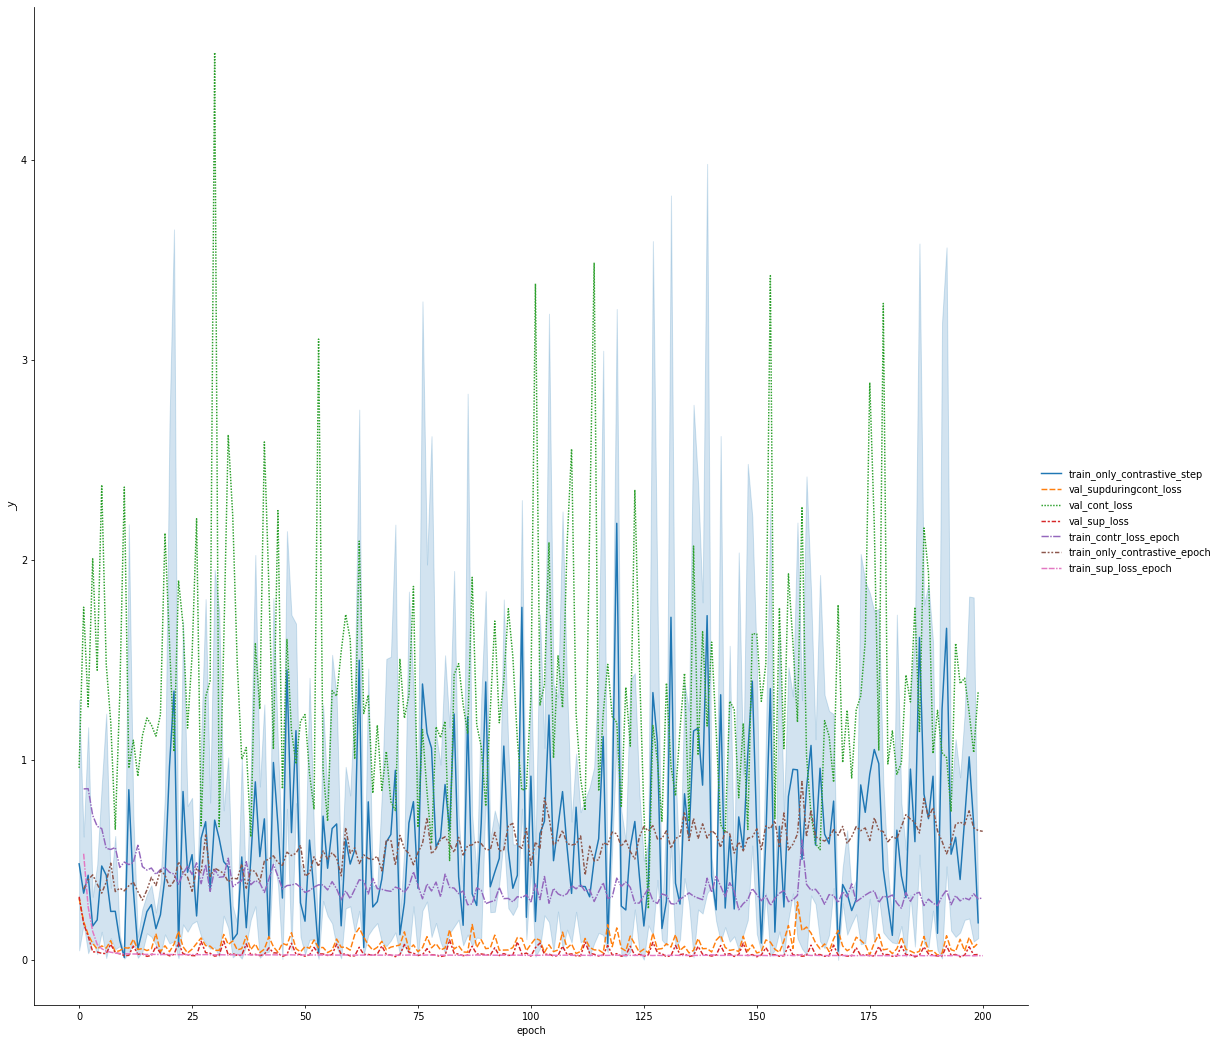

In [16]:
import pandas as pd
import seaborn as sn

plt.rcParams['figure.figsize'] = [4.0, 4.0]
plt.rcParams['figure.dpi'] = 70

#metrics = pd.read_csv('/home/charissa/shimogori/shimogori_adult/contrastive_learning/lightning_code/csvlogs/lightning_logs/version_6/metrics.csv')
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]

del metrics["train_loss_step"]  

del metrics["train_loss_epoch"]

del metrics['train_nce_loss']
del metrics['train_contr_loss_step']
del metrics['train_sup_loss_step']


metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line", height=15)

### Run inference on test set

In [ ]:
# inference
import cv2
import math
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity

# if loading model from file
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if True:
    segmodel2 = SegModel(hidden_dim=32, bottleneck_ch=64, bottleneck_h=24, bottleneck_w=24, lr=1e-3, temperature=.07, weight_decay=1e-4, p_conloss=1)  # preds_h,w = 6 for patch64,96, 3 for patch48
    segmodel2.load_state_dict(torch.load('/home/charissa/shimogori/shimogori_adult/segmentation/contrastive_learning/lightning_code/csvlogs/20221204_epochs500_2loaders_wpretrain/version_0/checkpoints/epoch=499-step=778500.ckpt')['state_dict'])  #ish_pth/20220219_unet3lvl_crop64_best_metric_model_91.pth'))
    #segmodel2.load_state_dict(torch.load('/home/charissa/shimogori/shimogori_adult/segmentation/contrastive_learning/lightning_code/csvlogs/20221031_epochs200_lsuplcont1_2pretrainloaders/version_0/checkpoints/epoch=199-step=34000.ckpt'))
    #segmodel2.eval()
    segmodel2.freeze()
    segmodel2.eval()

for cmp in cmp_ls: 
    test_dir = '/home/charissa/shimogori/shimogori_adult/ish/new/img_char_test2/'
    odir = test_dir.replace('gene','gene_seg')
    os.makedirs(odir, exist_ok=True) 
    
    with torch.no_grad():
        for j in range(0, len(test_f)):
            unique_name = os.path.split(test_f[j])[1]

            nibobj = nib.load(test_f[j])
            im = nibobj.get_fdata()

            im_t = tf.to_tensor(im)  
            im_t2 = torch.unsqueeze(im_t,0)
            _, pred = segmodel2(im_t2.float())

            pred_ = pred[0,0,:,:].numpy()
            im_out2 = rescale_intensity(pred_, in_range='image',out_range='uint8').astype(np.uint8) 

            print(out_name)
            
            new_im = nib.Nifti1Image(im_out2, nibobj.affine, nibobj.header)
            nib.save(new_im, out_name)

            if j % 10 == 0:
                plt.imshow(im_out2, cmap='gray')
                plt.show()